# Using Hydrosat's STAC API to search the catalog

This guide shows methods for using ```pystac``` with Hydrosat's SpatioTemporal Asset Catalog (STAC) API to search for data that meets your criteria. Topics covered include:
- Searching by collection name
- Searching by area of interest, including with a point geometry, polygon geometry, and bounding box
- Searching by date range
- Searching by metadata tag

## 1. Import dependencies.

In [29]:
import json
import pystac
from pystac_client import Client
import base64

## 2. Connect to the STAC API with your account credentials.

To run the next cell, you should have set up a `creds.json` file containing your username and password in the same directory as this notebook.

In [30]:
with open('creds.json') as f:
    creds = json.loads(f.read())

This next cell will endecode the `username:password` combination and use it to authorize access to the STAC API given by the `cat_url` endpoint. You don't need to make any changes here.

In [31]:
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://stac.hydrosat.com/'
catalog = Client.open(cat_url, headers)

## 3. Define your search terms.

The catalog contains VZ-1 imagery from around the globe. Let's start with a simple search of the catalog limited only by the collection of interest and the maximum total number of items. 

Be patient! You may need to wait several seconds for the response to your query.

In [32]:
collection_id = "vz-l2"

In [55]:
search = catalog.search(
    collections = collection_id,
    max_items=100) # Return a maximum of 500 items in collection

items_in_collection = list(search.item_collection())

print(f"Found {len(items_in_collection)} items.\n")

Found 68 items.



We'll write a function called ```show_footprints``` that uses ```geopandas``` to plot the bounding boxes for each item returned from our search.

**⚠️ Note:** Certain IDEs will render this map differently.
- If you're using VSCode, you'll see multiple interactive maps in this Jupyter notebook.
- If you're using Spyder, you'll need to run through entire notebook and open ```search-map.html```, which is saved at the end, in a browser window.

In [56]:
import geopandas as gpd

def show_footprints(items, color, map=None):
    gdf = gpd.GeoDataFrame.from_features(items, crs="epsg:4326")[["geometry"]]
    gdf['ID'] = [item.id for item in items]
    gdf['Date'] = [item.datetime.date().strftime('%Y-%m-%d') for item in items]
    gdf['Time (UTC)'] = [item.datetime.time().strftime('%H:%M:%S') for item in items]

    if map is None: # if this is the first call, create a new map
        return gdf.explore(color=color, style_kwds={"fillOpacity": 0.7, "weight": 1})
    else: # if we have already created a map, add to it
        return gdf.explore(m=map, color=color, style_kwds={"fillOpacity": 0.7, "weight": 1})

Let's try it out.

In [57]:
items_in_collection_color = 'red'

m = show_footprints(items_in_collection, color=items_in_collection_color)
m

In the map, the red squares represent scenes available in the ```vz-l2``` collection.

## 3.1 Searching by area of interest

We can add more criteria to ```catalog.search()``` to find data that intersects a specific location.

### 3.1.1 Searching with a point geometry

We'll start by defining a point geometry. This geometry will be used as an input to ```catalog.search()```. Any imagery that overlaps this point will be returned.

In [58]:
point_geom = {'type': 'Point', 'coordinates': [116.7478, -32.7153]}

In [37]:
search = catalog.search(
    collections = collection_id,
    intersects = point_geom
)

items_intersecting_point = list(search.item_collection())

print(f"Found {len(items_intersecting_point)} items.\n")

Found 1 items.



We'll plot the item footprint on a map, as before.

In [38]:
items_intersecting_point_color = 'orange'
m = show_footprints(items_intersecting_point, color=items_intersecting_point_color, map=m)
m

### 3.1.2 Searching with a polygon geometry

We can use any GeoJSON geometry type with ```intersects```, including a MultiPoint, LineString, MultiLineString, Polygon, or MultiPolygon. For example, we can define:

In [39]:
poly_geom = {'type': 'Polygon', 'coordinates': [[
            [
              -115.02617069030356,
              33.51297730941181
            ],
            [
              -108.63401434955702,
              33.51297730941181
            ],
            [
              -108.63401434955702,
              39.09484428364607
            ],
            [
              -115.02617069030356,
              39.09484428364607
            ],
            [
              -115.02617069030356,
              33.51297730941181
            ]
          ]]}

And repeat the search:

In [40]:
search = catalog.search(
    collections = collection_id,
    intersects = poly_geom
)

items_intersecting_poly = list(search.item_collection())

print(f"Found {len(items_intersecting_poly)} items.\n")

Found 6 items.



Let's plot the items we found.

In [41]:
items_intersecting_poly_color = 'yellow'
m = show_footprints(items_intersecting_poly, color=items_intersecting_poly_color, map=m)
m

### 3.1.3 Searching with a bounding box

Alternatively, we can search with a bounding box instead of using ```intersects```.

In [42]:
# [west, south, east, north]
bbox = [-123.044, 35.907, -118.834, 40.053]

In [43]:
search = catalog.search(
    collections = collection_id,
    bbox = bbox
)

items_intersecting_bbox = list(search.item_collection())

print(f"Found {len(items_intersecting_bbox)} items.\n")

Found 12 items.



Let's map the items.

In [44]:
items_intersecting_bbox_color = 'lime'
m = show_footprints(items_intersecting_bbox, color=items_intersecting_bbox_color, map=m)
m

## 3.2. Searching by date range

We can also specify the start and end dates (and times) for the search. Let's try another search.

In [59]:
start_date = "2025-07-01"
start_time = "T00:00:00Z"

end_date = "2025-07-15"
end_time = "T00:00:00Z"

In [60]:
search = catalog.search(
    collections = collection_id,
    datetime = [start_date+start_time, end_date+end_time]
)

items_in_daterange = list(search.item_collection())

print(f"Found {len(items_in_daterange)} items.\n")

Found 6 items.



Again, we'll visualize the scene footprints.

In [47]:
items_in_daterange_color = 'cyan'
m = show_footprints(items_in_daterange, color=items_in_daterange_color, map=m)
m

## 3.3 Searching by metadata tag

Anything listed under an item's ```properties``` is acceptable for use as a search filter (although some are more sensible filters than others). Let's look at an individual item to see the available ```properties```. 

In [48]:
items_in_daterange[0].properties

{'start_datetime': '2025-07-14T02:23:28.436021Z',
 'end_datetime': '2025-07-14T02:23:38.388531Z',
 'created': '2025-07-23T23:03:32.797Z',
 'hydrosat:scene_id': 'VZ01_L2_20250714_022333',
 'datetime': '2025-07-14T02:23:33.412276Z',
 'processing:lineage': 'Hydrosat Level-2 LST and SR processing',
 'eo:cloud_cover': 0.4135154214440202,
 'eo:snow_cover': 0,
 'hydrosat:capture_type': 'image',
 'hydrosat:day_night': 'day',
 'instruments': ['liri-v1-01', 'viri-v1-01'],
 'platform': 'vanzyl-01',
 'processing:software': {'vz-l1b': 'hydrosat.vz_l1b==0.0.0+dev-2025-07-14T16:56:16+0000',
  'vz-liri-l0': 'hydrosat.vz_liri_l0==0.18.2.dev133+g9f3cc60',
  'vz-liri-l0b': 'hydrosat.vz_liri_l0b==0.18.2.dev32+g1debc9d',
  'vz-liri-l1a': 'hydrosat.vz_liri_l1a==0.0.0+dev-2025-07-14T16:48:42+0000',
  'vz-telemetry': 'hydrosat.vz_telemetry==0.18.2.dev18+ga0564b2',
  'vz-viri-l0': 'hydrosat.vz_viri_l0==0.18.2.dev47+g16aefb1',
  'vz-viri-l1a': 'hydrosat.vz_viri_l1a==0.0.0+dev-2025-07-14T16:43:48+0000',
  'vz-l2

Let's try it out. 

We'll use the ```view:off_nadir``` property to constrain our search. Specifically, we only want images acquired with a predetermined off-nadir angle. To streamline our result, we'll use ```sortby``` to sort the items by increasing off-nadir angle. If we wanted to sort in descending order, we could substitute the "+" character in ```sortby``` for "-".

We'll also use the ```max_items``` argument to limit our search. Only that number of items with the smallest off-nadir angles in the collection will be returned.

In [61]:
search = catalog.search(
    collections = collection_id,
    query = {"view:off_nadir": {"gte": -2, "lte": 2}},
    sortby=["+properties.view:off_nadir"],
    max_items=5
)

items_nadir = list(search.item_collection())

print(f"Found {len(items_nadir)} items.\n")

Found 5 items.



Time to plot.

In [62]:
items_nadir_color = 'fuchsia'
m = show_footprints(items_nadir, color=items_nadir_color, map=m)
m.save("search-map.html")
m

## 4. Summary of approaches

Whether you're interested in searching for data by AOI, date range, metadata tag, or all of the above, you can configure ```catalog.search()``` to find what you need.

Let's summarize the number of items we retrieved with each search above.

In [51]:
n_items = [len(i) for i in [items_in_collection, items_intersecting_point, items_intersecting_poly, items_intersecting_bbox, items_in_daterange, items_nadir]]
colors = [items_in_collection_color, items_intersecting_point_color, items_intersecting_poly_color, items_intersecting_bbox_color, items_in_daterange_color, items_nadir_color]

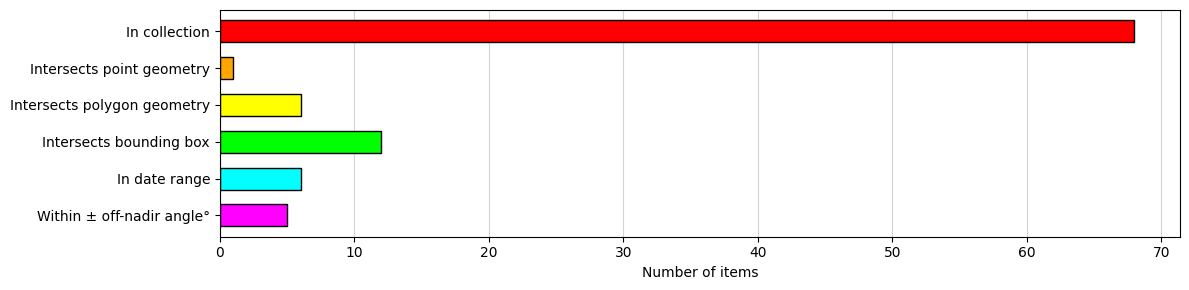

In [52]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,3))
plt.barh(y=range(len(n_items)), width=n_items[::-1], height=0.6,
         color=colors[::-1],
         edgecolor='k',
         zorder=2);
plt.yticks(range(len(n_items)),
          ['In collection', 'Intersects point geometry', 'Intersects polygon geometry', 'Intersects bounding box', 'In date range', 'Within ± off-nadir angle°'][::-1]);
plt.xlabel('Number of items')
plt.grid(which='major', axis='x', color='lightgray')
plt.tight_layout()
plt.show()